# WNBA Racial Biase Estiamation

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
import sklearn
import os

In [ ]:
RANDOM_SEED=60
np.random.seed(RANDOM_SEED)

##Load and Format WNBA Data

In [ ]:
wnba = pd.read_csv('clean_wnba.csv')
wnba.head()

encoder = LabelEncoder()
wnba = wnba[wnba['race'] != "Other"]
wnba['position'] = encoder.fit_transform(wnba['position'])
wnba['race'] = encoder.fit_transform(wnba['race'])
wnba['team'] = encoder.fit_transform(wnba['team'])
wnba['opponent'] = encoder.fit_transform(wnba['opponent'])

['ATL' 'CHI' 'CON' 'DAL' 'IND' 'LAS' 'LVA' 'MIN' 'NYL' 'PHO' 'SEA' 'STW'
 'TMW' 'WAS' 'WIL' 'WNT']


In [ ]:
wnba.head()

,Unnamed: 0,position,point_rate,steal_rate,block_rate,rebound_rate,foul_rate,race,matching_refs,time,team,opponent,majority_match
0,1,5,17.094017,0.000000,0.000000,2.136752,6.410256,0,0,18.72,1,4,0
1,2,5,4.637681,2.318841,0.000000,4.637681,4.637681,1,2,17.25,1,4,1
2,3,2,10.291595,0.000000,0.000000,6.861063,3.430532,0,0,23.32,1,4,0
3,4,1,20.125786,1.677149,1.677149,6.708595,3.354298,0,0,23.85,1,4,0
4,5,2,19.512195,3.001876,0.000000,1.500938,1.500938,0,0,26.65,1,4,0


In [ ]:
confounders = wnba.drop(columns=['foul_rate', 'matching_refs', 'Unnamed: 0', 'time', 'matching_refs'])
outcome = wnba['foul_rate']
treatment = wnba['majority_match']
treatment_confounder = wnba[['race', 'team', 'opponent']]
confounders.head()

,position,point_rate,steal_rate,block_rate,rebound_rate,race,team,opponent,majority_match
0,5,17.094017,0.000000,0.000000,2.136752,0,1,4,0
1,5,4.637681,2.318841,0.000000,4.637681,1,1,4,1
2,2,10.291595,0.000000,0.000000,6.861063,0,1,4,0
3,1,20.125786,1.677149,1.677149,6.708595,0,1,4,0
4,2,19.512195,3.001876,0.000000,1.500938,0,1,4,0


## Specify Nuisance Function Models

The next step is to specify models for the conditional expected outcome and propensity score

In [ ]:
# specify a model for the conditional expected outcome

# make a function that returns a sklearn model for later use in k-folding
def make_Q_model():
 return HistGradientBoostingRegressor(random_state=RANDOM_SEED)
Q_model = make_Q_model()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation

X_w_treatment = confounders.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Q_model.fit(X_train, y_train)
y_pred = Q_model.predict(X_test)

test_mse=mean_squared_error(y_pred, y_test)
print(f"Test MSE of fit model {test_mse}")
baseline_mse=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse}")

Test MSE of fit model 9.013751191476828
Test MSE of no-covariate model 9.429119415356066


In [ ]:
# specify a model for the propensity score

def make_g_model():
  return HistGradientBoostingClassifier(random_state=RANDOM_SEED)
# return LogisticRegression()
g_model = make_g_model()
# Sanity check that chosen model actually improves test error

X_train, X_test, a_train, a_test = train_test_split(treatment_confounder, treatment, test_size=0.2)
g_model.fit(X_train, a_train)
a_pred = g_model.predict_proba(X_test)

test_ce=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce}")
baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce}")

Test CE of fit model 0.6282288916876931
Test CE of no-covariate model 0.6743627615077793


## Use cross fitting to get get predicted outcomes and propensity scores for each unit

In [ ]:
# helper functions to implement the cross fitting

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A.
    That is,
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    for train_index, test_index in kf.split(X, A):
      X_train = X.iloc[train_index]
      A_train = A.iloc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.iloc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y.
    That is,
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    for train_index, test_index in kf.split(X_w_treatment, y):
      X_train = X_w_treatment.iloc[train_index]
      y_train = y.iloc[train_index]
      q = make_model()
      q.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = q.predict_proba(X0.iloc[test_index])[:, 1]
        predictions1[test_index] = q.predict_proba(X1.iloc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = q.predict(X0.iloc[test_index])
        predictions1[test_index] = q.predict(X1.iloc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [ ]:
g = treatment_k_fold_fit_and_predict(make_g_model, X=treatment_confounder, A=treatment, n_splits=10)

In [ ]:
Q0,Q1=outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates

,g,Q0,Q1,A,Y
0,0.305638,3.378168,3.378168,0,6.410256
1,0.605131,3.488395,3.488395,1,4.637681
2,0.339130,4.002929,4.002929,0,3.430532
3,0.280181,3.962886,3.962886,0,3.354298
4,0.339130,3.591930,3.591930,0,1.500938
...,...,...,...,...,...
15181,0.543819,3.704285,3.704285,1,1.619433
15182,0.335914,4.994669,4.994669,0,4.901961
15183,0.384656,5.922677,5.922677,0,0.000000
15185,0.352555,3.868711,3.868711,0,0.000000


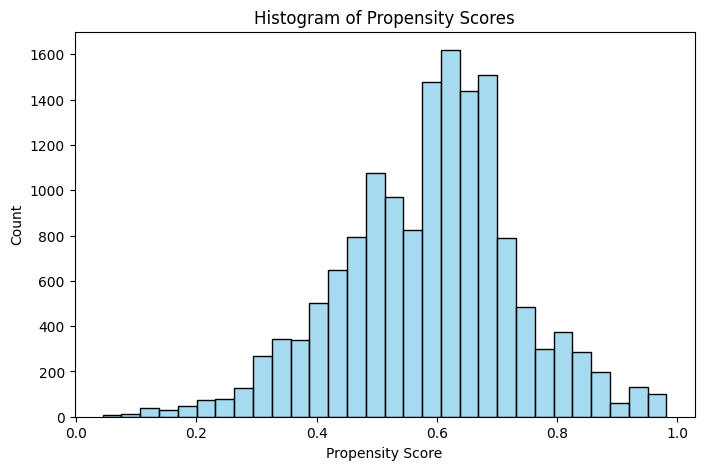

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the data — example: treated units only
subset = 1-g

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(subset, bins=30, kde=False, color='skyblue')
plt.title('Histogram of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.show()

## Combine predicted values and data into estimate of ATE

In [ ]:
def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATE
  """

  tau_hat = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g)).mean()

  scores = Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g) - tau_hat
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat

In [ ]:
def cate_aiptw(Q0, Q1, g, A, Y, V, prob_t=None):
  """
  # Double ML estimator for the CATE
  """
  tau_df = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g))
  mask = confounders['race'] == V
  tau_hat = tau_df[mask].mean()

  scores = tau_df[mask] - tau_hat
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat

In [ ]:
tau_hat, std_hat = ate_aiptw(**data_and_nuisance_estimates)
print(f"The ATE estimate is {tau_hat} pm {1.96*std_hat}")

The estimate is 0.037921681631991895 pm 0.10842512165859024


In [ ]:
tau_hat, std_hat = cate_aiptw(**data_and_nuisance_estimates, V=0)
print(f"The CATE estimate for Black players is {tau_hat} pm {1.96*std_hat}")

tau_hat, std_hat = cate_aiptw(**data_and_nuisance_estimates, V=1)
print(f"The CATE estimate for white players is {tau_hat} pm {1.96*std_hat}")

The estimate is 0.08573358044350546 pm 0.10495986561543583
The estimate is -0.10409058772469412 pm 0.11809047523442216


### Sensitivity Analysis

In [ ]:
import pathlib
from austen_plots.AustenPlot import AustenPlot
target_bias = 0.100

covariate_groups = {
    'player': ['race', 'position'],
    'stats': ['point_rate', 'steal_rate', 'block_rate', 'rebound_rate'],
    'game': ['team', 'opponent']}

# For each covariate group, refit the models without using that group
nuisance_estimates = {}
for group, covs in covariate_groups.items():
  remaining_treatment_confounders = treatment_confounder
  try:
    remaining_confounders = confounders.drop(columns=covs)
    remaining_treatment_confounders = treatment_confounder.drop(columns=covs)
  except:
    pass

  g = treatment_k_fold_fit_and_predict(make_g_model, X=remaining_treatment_confounders, A=treatment, n_splits=5)
  Q0, Q1 = outcome_k_fold_fit_and_predict(make_Q_model, X=remaining_confounders, y=outcome, A=treatment, n_splits=5, output_type="continuous")

  data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})
  nuisance_estimates[group] = data_and_nuisance_estimates

In [ ]:
data_and_nuisance_path = 'data_and_nuisance_estimates.csv'
covariate_dir_path = 'covariates/'

def _convert_to_austen_format(nuisance_estimate_df: pd.DataFrame):
  austen_df = pd.DataFrame()
  austen_df['y']=nuisance_estimate_df['Y']
  austen_df['t']=nuisance_estimate_df['A']
  austen_df['g']=nuisance_estimate_df['g']
  A = nuisance_estimate_df['A']
  austen_df['Q']=A*nuisance_estimate_df['Q1'] + (1-A)*nuisance_estimate_df['Q0'] # use Q1 when A=1, and Q0 when A=0
  return austen_df

austen_data_and_nuisance = _convert_to_austen_format(data_and_nuisance_estimates)
austen_data_and_nuisance.to_csv(data_and_nuisance_path, index=False)

pathlib.Path(covariate_dir_path).mkdir(exist_ok=True)
for group, nuisance_estimate in nuisance_estimates.items():
  austen_nuisance_estimate = _convert_to_austen_format(nuisance_estimate)
  austen_nuisance_estimate.to_csv(os.path.join(covariate_dir_path,group+".csv"), index=False)

Fitting main dataset


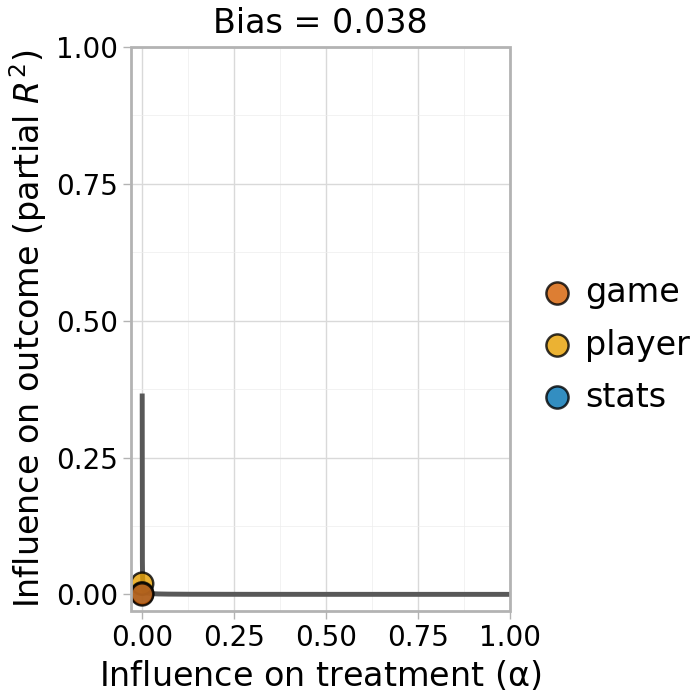

In [ ]:
ap = AustenPlot(data_and_nuisance_path, covariate_dir_path)

p, plot_coords, variable_coords = ap.fit(bias=0.038)

p